## <p style="text-align: center;">B9AI103_2122_TMD3_CA_1</p>
### <p style="text-align: center;"> Details </p>
#### <p style="text-align: center;">Name: Sunil Judhistira Gauda</p>
#### <p style="text-align: center;">Student ID : 10595858 </p>

## Hybrid Movie Recommendation using Movie Lense Data set

###### Links: [MovieLens (GroupLens)](https://grouplens.org/datasets/movielens/latest/)

## Business Undestanding

Developing a movie recommendation system that will recommend using hybrid content + colaberative based filtering using a nural network as a model.

## Step 0: Setup

### Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

## Step 1: Data Undestanding

### Import data & Data Representation

Note : 
- Please Change the directory as per the location of the dataset in your system

In [2]:
# Movies
dtf_movies = pd.read_csv("../../../../DataSets/ml-latest-small/movies.csv")
# dtf_movies = pd.read_csv("/content/movies.csv")
dtf_movies = dtf_movies.replace('-','', regex = True)

#### Exploring Data
- Movie data contains Date appended to title
- Title needs to be seperated from the movies
- **Date** Column is added to the movies

In [3]:
dtf_movies = dtf_movies[~dtf_movies["genres"].isna()]
dtf_movies["product"] = range(0,len(dtf_movies))
dtf_movies["title"] = dtf_movies["title"].replace('-','')
dtf_movies["title"] = dtf_movies["title"].apply(lambda x: re.sub(r'\(\D+\)', "", x))
dtf_movies["name"] = dtf_movies["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())

 

dtf_movies["date"] = dtf_movies["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) 
                                                             if "(" in x else np.nan)                                                       

## add features
dtf_movies["date"] = dtf_movies["date"].fillna(9999)
dtf_movies["old"] = dtf_movies["date"].apply(lambda x: 1 if x < 2000 else 0)

dtf_movies

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9737,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9738,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9739,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9740,Bungo Stray Dogs: Dead Apple,2018.0,0


### Exploring Ratings Data
- Ratings conatin user Specific ratings for each movies
- **daytime, weekend** is added to the the data set

In [4]:
 # Users
dtf_users = pd.read_csv("../../../../DataSets/ml-latest-small/ratings.csv")
dtf_users

dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)

dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

dtf_users = dtf_users.merge(dtf_movies[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 19:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 19:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 19:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 20:03:35,0,0,1,43
4,1,50,5.0,2000-07-30 19:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 22:53:22,609,0,0,9434
100832,610,168248,5.0,2017-05-03 23:21:31,609,0,0,9461
100833,610,168250,5.0,2017-05-08 20:50:47,609,0,0,9462
100834,610,168252,5.0,2017-05-03 22:19:12,609,0,0,9463


### Cleaning the movies dataset
- keeping the Required Columns and cleaning the dataset

In [5]:
# select only useful columns
dtf_movies = dtf_movies[["product","old","name","genres"]].set_index("product")
dtf_movies.head()

,old,name,genres
product,,,
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji,Adventure|Children|Fantasy
2,1,Grumpier Old Men,Comedy|Romance
3,1,Waiting to Exhale,Comedy|Drama|Romance
4,1,Father of the Bride Part II,Comedy


In [6]:
# extract context
dtf_context = dtf_users[["user","product","daytime","weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,0,1
4,0,46,1,1


In [7]:
dtf_users = dtf_users[["user","product","y"]]
dtf_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


## Step 2: Data Analysis

### Exploring Products
- Products define what catagory of genre our movies fall into.
- we are trying to explore the genre in the movies dataset

In [8]:
tags = [i.split("|") for i in dtf_movies["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['FilmNoir', 'Fantasy', 'Horror', 'IMAX', 'Crime', 'Musical', 'War', 'SciFi', 'Documentary', 'Mystery', 'Animation', 'Children', 'Comedy', 'Action', 'Thriller', 'Drama', 'Adventure', 'Western', 'Romance']


In [9]:
for col in columns:
    dtf_movies[col] = dtf_movies["genres"].apply(lambda x: 1 if col in x else 0)
dtf_movies.head()

,old,name,genres,FilmNoir,Fantasy,Horror,IMAX,Crime,Musical,War,...,Mystery,Animation,Children,Comedy,Action,Thriller,Drama,Adventure,Western,Romance
product,,,,,,,,,,,,,,,,,,,,,
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,0
1,1,Jumanji,Adventure|Children|Fantasy,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,Grumpier Old Men,Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,Waiting to Exhale,Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,1,Father of the Bride Part II,Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Plotting Products with features

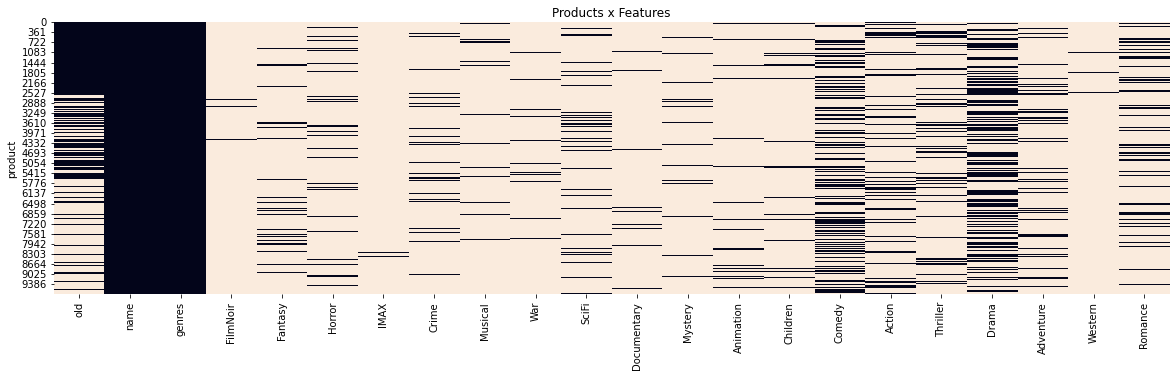

In [10]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_movies==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

### Exploring Rating of Users

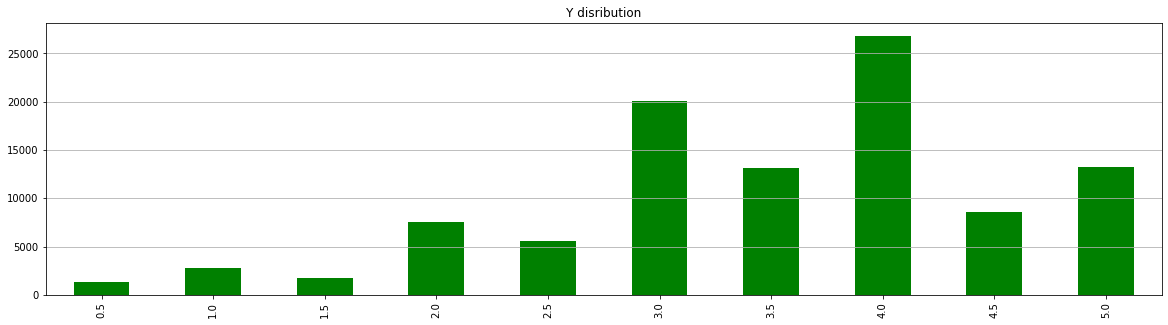

In [11]:
dtf_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution", 
                                                figsize=(20,5)).grid(axis='y')
plt.show()

In [12]:
dtf_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


### Pivoting Chunkwise to avoid memory constaint

In [13]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_movies.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting a heat-map pf the user rating to each product

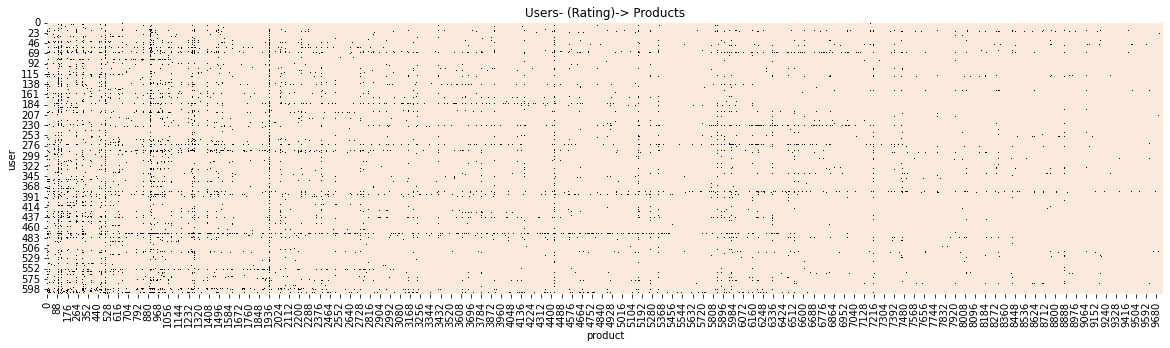

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users- (Rating)-> Products")
plt.show()

## Step 3: Preprocessing
- Scaling
- Partitioning

### Scaling

In [15]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Partitioning

In [16]:
split = int(0.8*dtf_users.shape[1])
split

7793

### Preparing the training data

In [17]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 94054


product,0,1,2,3,4,5,6,7,8,9,...,7783,7784,7785,7786,7787,7788,7789,7790,7791,7792
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preparing Test Data Set

In [18]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 6782


product,7793,7794,7795,7796,7797,7798,7799,7800,7801,7802,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 3 - Modelling

### Preparing a Baseline Content-Based Model

In [19]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7793,NaN
7794,NaN
7795,NaN
7796,NaN
7797,NaN


In [20]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.tail()

,y
product,
9737,NaN
9738,NaN
9739,NaN
9740,NaN
9741,NaN


### Preparing Data for Model

In [21]:
usr = train[["y"]].fillna(0).values.T
prd = dtf_movies.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9742)  x  Products (9742, 20)


In [22]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
270,8063,0.812500,0.367409
512,8305,1.000000,0.446949
583,8376,0.777778,0.071390
673,8466,0.875000,0.211218
716,8509,0.500000,0.467547
757,8550,0.833333,0.348377
888,8681,1.000000,0.328201
1035,8828,0.500000,0.030355


In [23]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [24]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
mrr: 0.26


In [25]:
test.merge(
        dtf_movies[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
716,8509,0.500000,0.467547,The Drop,0,Crime|Drama|Thriller
512,8305,1.000000,0.446949,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
270,8063,0.812500,0.367409,Django Unchained,0,Action|Drama|Western
757,8550,0.833333,0.348377,Ex Machina,0,Drama|SciFi|Thriller
888,8681,1.000000,0.328201,Mad Max: Fury Road,0,Action|Adventure|SciFi|Thriller
673,8466,0.875000,0.211218,Whiplash,0,Drama
583,8376,0.777778,0.071390,Interstellar,0,SciFi|IMAX
1035,8828,0.500000,0.030355,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


###  Model Desing & Testing for Collaborative Filtering

### Data preparation for collaberative filtering

In [26]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [27]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000


### Model Design for collaberative based filtering

In [28]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
print("Collaborative Filetering")
model.summary()

Collaborative Filetering
Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                    

### Train, Test and Visualisation of performance 

In [29]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

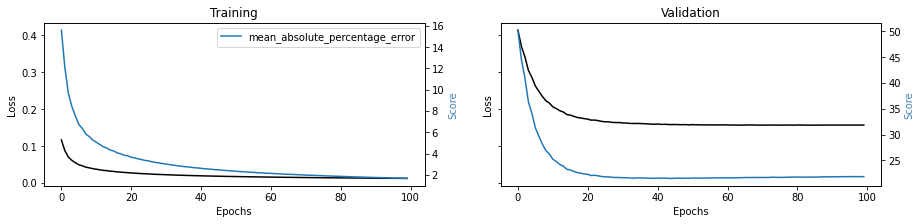

In [31]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [32]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

212/212 [==============================] - 1s 2ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.843352
1,1,8305,1.000000,0.705596
2,1,8376,0.777778,0.792307
3,1,8466,0.875000,0.755032
4,1,8509,0.500000,0.720826
...,...,...,...,...
6777,609,9434,0.937500,0.905424
6778,609,9461,1.000000,0.827013
6779,609,9462,1.000000,0.865734
6780,609,9463,1.000000,0.833478


## Evaluate - Collaberative Filtering

In [33]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.25%


In [34]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8063 8828 8376 8466 8509]
true positive: 2 (40.0%)
accuracy: 0.0%
mrr: 0.25


In [35]:
test[test["user"]==i].merge(
        dtf_movies[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
0,1,8063,0.812500,0.843352,Django Unchained,0,Action|Drama|Western
7,1,8828,0.500000,0.833230,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
2,1,8376,0.777778,0.792307,Interstellar,0,SciFi|IMAX
3,1,8466,0.875000,0.755032,Whiplash,0,Drama
4,1,8509,0.500000,0.720826,The Drop,0,Crime|Drama|Thriller
1,1,8305,1.000000,0.705596,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
5,1,8550,0.833333,0.625804,Ex Machina,0,Drama|SciFi|Thriller
6,1,8681,1.000000,0.569200,Mad Max: Fury Road,0,Action|Adventure|SciFi|Thriller


### Step 5 - Modelling for Neural Collaborative Filtering

### Data Preparation

In [36]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [37]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000


### Model Design

In [38]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
print("Collaborative Filtering")
model.summary()

Collaborative Filtering
Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                              

### Train / Test and visualize

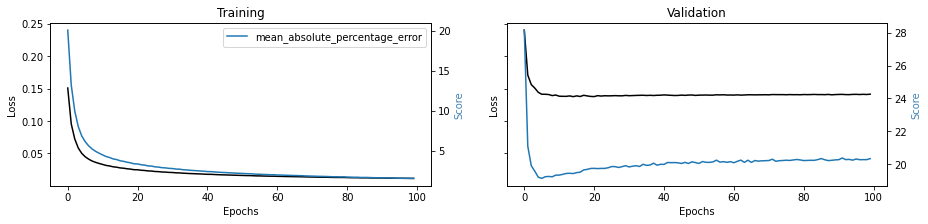

In [39]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [40]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

212/212 [==============================] - 1s 2ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.859812
1,1,8305,1.000000,0.820861
2,1,8376,0.777778,0.720153
3,1,8466,0.875000,0.703826
4,1,8509,0.500000,0.854555
...,...,...,...,...
6777,609,9434,0.937500,0.701269
6778,609,9461,1.000000,0.757105
6779,609,9462,1.000000,0.743083
6780,609,9463,1.000000,0.939568


### Evaluate Neural Network with Colaberative Filtering

In [41]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.22%


In [42]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8550 8828 8063 8681 8509]
true positive: 3 (60.0%)
accuracy: 0.0%
mrr: 0.32


In [43]:
test[test["user"]==i].merge(
        dtf_movies[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
5,1,8550,0.833333,1.029113,Ex Machina,0,Drama|SciFi|Thriller
7,1,8828,0.500000,0.861210,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
0,1,8063,0.812500,0.859812,Django Unchained,0,Action|Drama|Western
6,1,8681,1.000000,0.854959,Mad Max: Fury Road,0,Action|Adventure|SciFi|Thriller
4,1,8509,0.500000,0.854555,The Drop,0,Crime|Drama|Thriller
1,1,8305,1.000000,0.820861,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
2,1,8376,0.777778,0.720153,Interstellar,0,SciFi|IMAX
3,1,8466,0.875000,0.703826,Whiplash,0,Drama


## Steap 6 - Hybrid Model

### Data Preparation

In [44]:
# Extra data
features = dtf_movies.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

Index(['old', 'FilmNoir', 'Fantasy', 'Horror', 'IMAX', 'Crime', 'Musical',
       'War', 'SciFi', 'Documentary', 'Mystery', 'Animation', 'Children',
       'Comedy', 'Action', 'Thriller', 'Drama', 'Adventure', 'Western',
       'Romance'],
      dtype='object')
Index(['daytime', 'weekend'], dtype='object')


In [45]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_movies[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

,user,product,y,old,FilmNoir,Fantasy,Horror,IMAX,Crime,Musical,...,Children,Comedy,Action,Thriller,Drama,Adventure,Western,Romance,daytime,weekend
0,0,0,0.888889,1,0,1,0,0,0,0,...,1,1,0,0,0,1,0,0,1,1
1,0,2,0.888889,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
2,0,5,0.875000,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,1
3,0,43,1.000000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,46,1.000000,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1


In [46]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_movies.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0 #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

,user,product,y,old,FilmNoir,Fantasy,Horror,IMAX,Crime,Musical,...,Children,Comedy,Action,Thriller,Drama,Adventure,Western,Romance,daytime,weekend
0,1,8063,0.812500,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
1,1,8305,1.000000,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,1,8376,0.777778,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,8466,0.875000,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,8509,0.500000,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0


### Model Design for Hybrid Nural network Movie recommendataion

In [47]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
print("Hybrid_Model")
model.summary()

Hybrid_Model
Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                                          

### Train / Test and Visualize

In [48]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

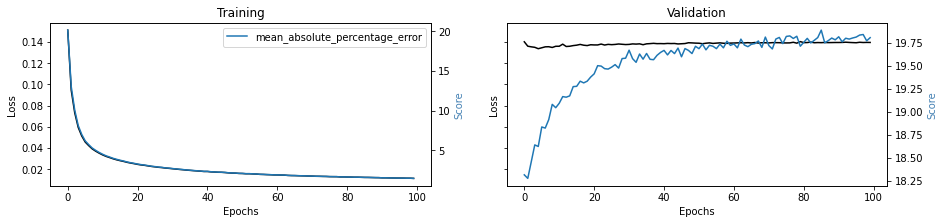

In [49]:
model = training.model
utils_plot_keras_training(training)

In [50]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

212/212 [==============================] - 1s 2ms/step


,user,product,y,old,FilmNoir,Fantasy,Horror,IMAX,Crime,Musical,...,Comedy,Action,Thriller,Drama,Adventure,Western,Romance,daytime,weekend,yhat
0,1,8063,0.812500,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0.764106
1,1,8305,1.000000,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0.850179
2,1,8376,0.777778,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.769964
3,1,8466,0.875000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.732763
4,1,8509,0.500000,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0.799598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6777,609,9434,0.937500,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0.693789
6778,609,9461,1.000000,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0.702174
6779,609,9462,1.000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.681343
6780,609,9463,1.000000,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.753107


In [51]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.22%


In [52]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8305 8509 8376 8550 8063]
true positive: 3 (60.0%)
accuracy: 60.0%
mrr: 0.29


In [53]:
import pprint
from tabulate import tabulate

y_test_list = list(y_test)
predicted_list = list(predicted)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint("#############  Movies Ideally to be Predicted  ###################")
print(tabulate(dtf_movies.iloc[y_test_list], headers='keys', tablefmt='psql'))
pp.pprint("#############  Movies Actually Predicted ###################")
print(tabulate(dtf_movies.iloc[predicted_list], headers='keys', tablefmt='psql'))





'#############  Movies Ideally to be Predicted  ###################'
+-----------+-------+--------------------------+---------------------------------+------------+-----------+----------+--------+---------+-----------+-------+---------+---------------+-----------+-------------+------------+----------+----------+------------+---------+-------------+-----------+-----------+
|   product |   old | name                     | genres                          |   FilmNoir |   Fantasy |   Horror |   IMAX |   Crime |   Musical |   War |   SciFi |   Documentary |   Mystery |   Animation |   Children |   Comedy |   Action |   Thriller |   Drama |   Adventure |   Western |   Romance |
|-----------+-------+--------------------------+---------------------------------+------------+-----------+----------+--------+---------+-----------+-------+---------+---------------+-----------+-------------+------------+----------+----------+------------+---------+-------------+-----------+-----------|
|      8305 |

In [54]:
dtf_movies

,old,name,genres,FilmNoir,Fantasy,Horror,IMAX,Crime,Musical,War,...,Mystery,Animation,Children,Comedy,Action,Thriller,Drama,Adventure,Western,Romance
product,,,,,,,,,,,,,,,,,,,,,
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,0
1,1,Jumanji,Adventure|Children|Fantasy,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,Grumpier Old Men,Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,Waiting to Exhale,Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,1,Father of the Bride Part II,Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,0,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
9738,0,No Game No Life: Zero,Animation|Comedy|Fantasy,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
9739,0,Flint,Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
